In [1]:
# | default_exp models.dlinear

In [10]:
# | export
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn

In [11]:
# | export
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

# Auxiliary Class

In [66]:
# | export


import torch.nn.functional as F
from statsmodels.tsa.seasonal import seasonal_decompose


class SeriesDecompose(nn.Module):
    def __init__(self, kernel_size, period=12):
        """
        Decomposes a time series into trend, seasonal, and residual components.

        :param kernel_size: The size of the kernel for moving average.
        :param period: The seasonal period for decomposition.
        """
        super(SeriesDecompose, self).__init__()
        self.kernel_size = kernel_size
        self.period = period
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)

    def forward(self, x):
        device = x.device  # Ensure consistency with input tensor device

        if x.dim() == 3:  # If input is 3D (batch, features, seq_len)
            batch, features, seq_len = x.shape
            x = x.view(batch, features * seq_len)  # Flatten only across sequence

        # Convert to NumPy (only first batch)
        x_np = x[0].detach().cpu().numpy()  # Convert only the first time series

        # Perform seasonal decomposition
        decompose = seasonal_decompose(
            x_np, period=self.period, model="additive", extrapolate_trend="freq"
        )

        # Convert back to PyTorch tensors
        trend = torch.tensor(decompose.trend, device=device, dtype=x.dtype)
        seasonal = torch.tensor(decompose.seasonal, device=device, dtype=x.dtype)
        residual = torch.tensor(decompose.resid, device=device, dtype=x.dtype)

        return trend, seasonal, residual


# class SeriesDecompose(nn.Module):
#     def __init__(self,kernel_size):
#         super(SeriesDecompose, self).__init__()
#         self.kernel_size = kernel_size
#         self.avg = nn.AvgPool1d(kernel_size=kernel_size,stride=1, padding=0)

#     def forward(self,x):
#         if x.dim() == 3:  # If input is 3D (batch, features, seq_len)
#             batch, features, seq_len = x.shape
#             x = x.view(batch ,features *  seq_len)

#         # apply padding to keep the result to be of same size
#         x_padded = torch.cat([x[:,0:1].repeat(1, (self.kernel_size - 1 )//2),
#              x,
#              x[:,-1:].repeat(1,(self.kernel_size - 1 )//2)],dim=1)
#         # moving_avg = self.avg(x_padded)  #.squeeze(1)
#         decompose = seasonal_decompose(x.flatten().cpu(),period=12)

#         # residual = x - moving_avg
#         return torch.tensor(decompose.trend,device=device) , torch.tensor(decompose.seasonal,device=device) , torch.tensor(decompose.resid,device=device)

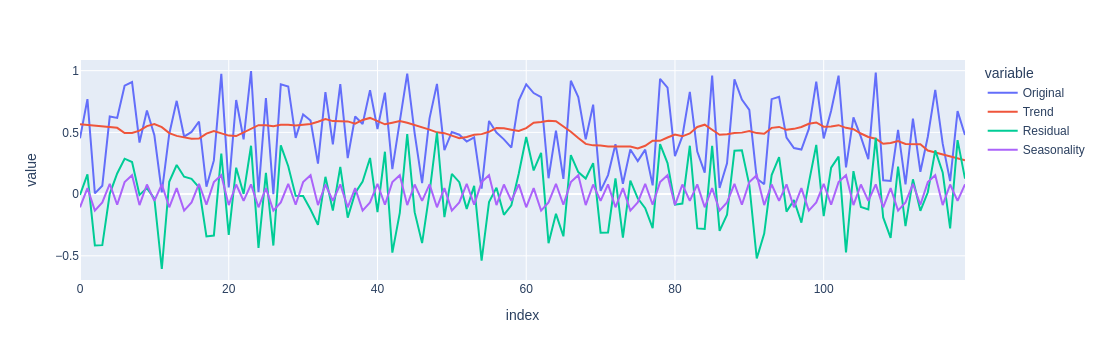

In [67]:
# | hide
import plotly.express as px

x = torch.rand(1, 1, 12 * 10)
# x = torch.tensor(df.y.values).view(1,-1)
trend, seasonality, residual = SeriesDecompose(kernel_size=13)(x)
ts = pd.DataFrame(
    {
        "Original": x.flatten().numpy(),
        "Trend": trend.flatten().cpu().numpy(),
        "Residual": residual.flatten().cpu().numpy(),
        "Seasonality": seasonality.flatten().cpu().numpy(),
    }
)
px.line(ts)

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose = seasonal_decompose(df['y'],period=12)
# decompose.plot();

In [69]:
# Model

In [70]:
class Dlinear(pl.LightningModule):
    def __init__(self, in_features, out_features, moving_avg_window, lr=1e-3):
        super().__init__()

        if moving_avg_window % 2 == 0:
            raise Exception("moving_avg_window should be odd")
        self.in_features = in_features
        self.decompose = SeriesDecompose(kernel_size=moving_avg_window)
        self.trend_linear = nn.Linear(
            in_features=in_features, out_features=out_features, bias=True
        )
        self.residual_linear = nn.Linear(in_features, out_features, bias=True)
        self.seasonality_linear = nn.Linear(in_features, out_features, bias=True)

        self.loss = nn.HuberLoss()
        self.lr = lr
        self._init_weights()

    def _init_weights(self):
        for layer in [self.trend_linear, self.residual_linear, self.seasonality_linear]:
            nn.init.constant_(layer.weight, val=1 / self.in_features)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        trend, seasonality, residual = self.decompose(x)
        # print("Trend:", trend.mean().item(), "Residual:", residual.mean().item())
        return (
            self.trend_linear(trend)
            + self.seasonality_linear(seasonality)
            + self.residual_linear(residual)
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_pred = self(x)
    #     loss = self.loss(y_pred, y)
    #     self.log("val_loss", loss, prog_bar=True, logger=True)

    # def test_step(self, batch, batch_idx):
    #     x, y = batch
    #     y_pred = self(x)
    #     loss = self.loss(y_pred, y)
    #     self.log("test_loss", loss, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [85]:
from neuralforecast.utils import AirPassengersDF as df

from ts.preprocess.dataloader import TSDataLoader

## Hyper Parameters
in_features, out_features, window, batch_sz = 24, 12, 1, 32 * 12
moving_avg_window = 3

In [86]:
df.y = torch.rand(len(df))

In [87]:
ds = TSDataLoader(df, in_features, out_features, window, batch_sz)
model = Dlinear(in_features, out_features, moving_avg_window).to(device)
# model = torch.compile(model)
trainer = pl.Trainer(max_epochs=1000, val_check_interval=1, logger=None, accelerator=device)
trainer.fit(model, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params | Mode 
---------------------------------------------------------------
0 | decompose          | SeriesDecompose | 0      | train
1 | trend_linear       | Linear          | 300    | train
2 | residual_linear    | Linear          | 300    | train
3 | seasonality_linear | Linear          | 300    | train
4 | loss               | HuberLoss       | 0      | train
---------------------------------------------------------------
900       Trainable params
0         Non-trainable params
900       Total params
0.004     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

/home/pranav-pc/.cache/pypoetry/virtualenvs/ts-EBaOKu-T-py3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:1100: UserWarning:

Using a target size (torch.Size([65, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [88]:
# trainer.validate(model, ds);

In [89]:
# trainer.test(model, ds);

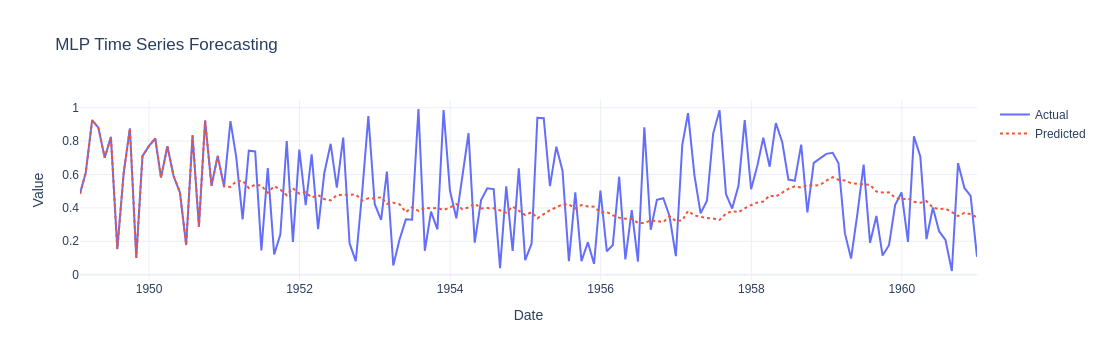

In [90]:
from ts.commons.plot_forecast import mlp_dms_singular, mlp_ims_singular

mlp_dms_singular(df, model, in_features, out_features, window)

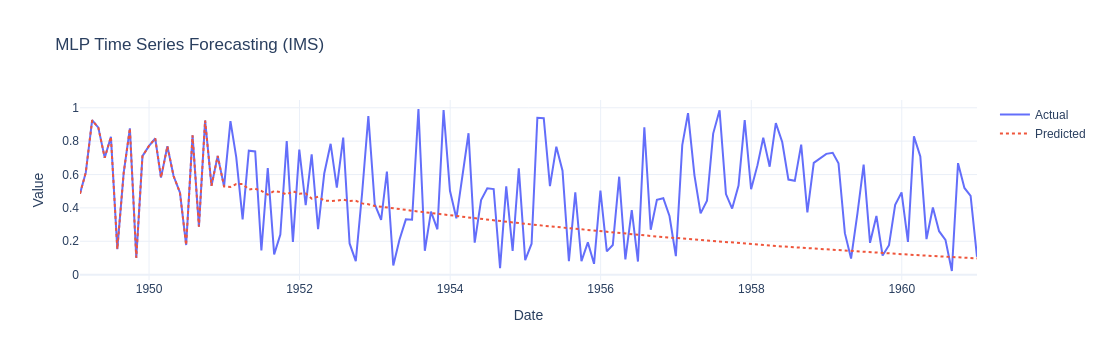

In [91]:
mlp_ims_singular(df, model, in_features, out_features, window)

In [55]:
import logging

import pandas as pd
from neuralforecast.models import DLinear
from neuralforecast.utils import AirPassengersDF
from utilsforecast.plotting import plot_series

from neuralforecast import NeuralForecast

In [56]:
# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds <= "1959-12-31"]  # 132 train
Y_test_df = Y_df[Y_df.ds > "1959-12-31"]  # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
# models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=100, enable_progress_bar=False),
# NHITS(input_size=2 * horizon, h=horizon, max_steps=100, enable_progress_bar=False)]
models = [DLinear(input_size=in_features, h=12)]
nf = NeuralForecast(models=models, freq="ME")
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict()

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | linear_trend  | Linear        | 84     | train
5 | linear_season | Linear        | 84     | train
--------------------------------------------------------
168       Trainable params
0         Non-trainable params
168       Total params
0.001     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=5000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

/home/pranav-pc/.cache/pypoetry/virtualenvs/ts-EBaOKu-T-py3.12/lib/python3.12/site-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [57]:
Y_hat_df = nf.predict_insample()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

/home/pranav-pc/.cache/pypoetry/virtualenvs/ts-EBaOKu-T-py3.12/lib/python3.12/site-packages/neuralforecast/core.py:214: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [58]:
Y_hat_df.reset_index(drop=False).drop(["cutoff", "ds"], axis=1)

,unique_id,DLinear,y
0,1.0,0.372726,112.0
1,1.0,0.300181,118.0
2,1.0,0.917557,132.0
3,1.0,0.515651,129.0
4,1.0,0.318772,121.0
...,...,...,...
1447,1.0,534.401917,559.0
1448,1.0,465.724609,463.0
1449,1.0,402.904083,407.0
1450,1.0,358.097015,362.0


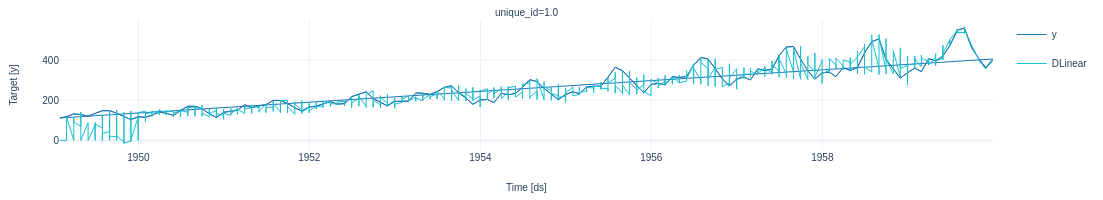

In [59]:
# Plot predictions
plot_series(Y_train_df, Y_hat_df.reset_index(drop=False).drop(["cutoff"], axis=1), engine="plotly")

In [60]:
plot_series(forecasts_df=Y_hat_df.reset_index(drop=False), engine="plotly")